In [198]:
# Using https://towardsdatascience.com/building-an-image-similarity-search-engine-with-faiss-and-clip-2211126d08fa

In [208]:
import os
from glob import glob
from PIL import Image
import numpy as np
import faiss
from sentence_transformers import SentenceTransformer
import matplotlib.pyplot as plt
import random
from PIL import Image, ImageDraw
import math 



### Get Hexagon Pictures

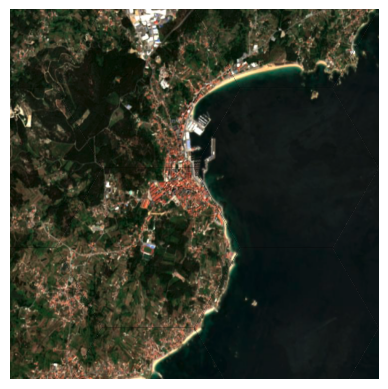

In [244]:
hex_radius = 150
IMAGE = '2018'
img = Image.open(f'./../images/{IMAGE}.png')
hex_height = math.sqrt(3) * hex_radius
hex_width = 2 * hex_radius
size = img.size[0] // hex_width
size_width = math.ceil(img.size[1] / hex_height ) +2
size_height = math.ceil(img.size[0] / hex_width) +2



def hex_corner(center, size, i):
      """Helper function to calculate hexagon corners."""
      angle_deg = 60 * i
      angle_rad = math.pi / 180 * angle_deg
      return (center[0] + size * math.cos(angle_rad), center[1] + size * math.sin(angle_rad))

def crop_hexagon(hex_image,center):
      """Draw a hexagon on the Pygame surface."""
      
      corners = [hex_corner(center, hex_radius, i) for i in range(6)]
      mask = Image.new("RGBA", (hex_image.size[0],hex_image.size[1]))
      draw = ImageDraw.Draw(mask)
      draw.polygon(list(corners), fill='green', outline='red')
      
      background = Image.new("RGBA", hex_image.size, (0,0,0,0))
      new_img = Image.composite(hex_image, background, mask)
      return new_img

def get_hexagons():
      hex_segments = []
      hex_pos = []
      hex_image = img
      for q in range(size_height):
            # hex_segments.append([])
            # hex_pos.append([])
            for r in range(size_width):
                  x = r * (hex_width - (math.cos(1.0472) * hex_radius)) 
                  y = q * (hex_height) + ((r%2) * math.sin(1.0472) * hex_radius) 
                  hex_image = crop_hexagon(img, (x, y))
                  hex_segments.append(hex_image)
                  hex_pos.append([x,y])

      return hex_segments, hex_pos
# Display some hexagons



# Get hexagonal segments and their positions
hexagons, positions = get_hexagons()


os.mkdir(f'./../images/{IMAGE}/')

for (x, y), hex_img in zip(positions, hexagons):
      imageBox = hex_img.getbbox()
      cropped = hex_img.crop(imageBox)
      
      cropped.save(f'./../images/{IMAGE}/{x}_{y}.png')

      


# Visualization with matplotlib
fig, ax = plt.subplots()
ax.set_aspect('equal')

# Plot each hexagon in its correct position
for (x, y), hex_img in zip(positions, hexagons):
    ax.imshow(hex_img)

ax.set_xlim(0, img.size[0])
ax.set_ylim(img.size[1], 0)
ax.axis('off')

plt.show()


### Extract Features

In [210]:
model = SentenceTransformer('clip-ViT-B-32')

In [245]:
def generate_clip_embeddings(images_path, model):
      
    image_paths = glob(os.path.join(images_path, '**/*.png'), recursive=True)
    
    embeddings = []
    for img_path in image_paths:
        image = Image.open(img_path)
        embedding = model.encode(image)
        embeddings.append(embedding)
    
    return embeddings, image_paths



IMAGES_PATH = f'./../images/{IMAGE}/'

embeddings, image_paths = generate_clip_embeddings(IMAGES_PATH, model)



In [249]:
def create_faiss_index(embeddings, image_paths, output_path):
      
    dimension = len(embeddings[0])
    index = faiss.IndexFlatIP(dimension)
    index = faiss.IndexIDMap(index)
    
    vectors = np.array(embeddings).astype(np.float32)

    # Add vectors to the index with IDs
    index.add_with_ids(vectors, np.array(range(len(embeddings))))
    
    # Save the index
    faiss.write_index(index, output_path)
    print(f"Index created and saved to {output_path}")
    
    # Save image paths
    with open(output_path + '.paths', 'w') as f:
        for img_path in image_paths:
            f.write(img_path + '\n')
    
    return index


OUTPUT_INDEX_PATH = f'./../images/{IMAGE}/indexes/index'
os.mkdir(f'./../images/{IMAGE}/indexes/')
index = create_faiss_index(embeddings, image_paths, OUTPUT_INDEX_PATH)

Index created and saved to ./../images/2018/indexes/index


In [255]:
def load_faiss_index(index_path):
      index = faiss.read_index(index_path)
      with open(index_path + '.paths', 'r') as f:
            image_paths = [line.strip() for line in f]
      print(f"Index loaded from {index_path}")
      return index, image_paths

index, image_paths = load_faiss_index(OUTPUT_INDEX_PATH)

Index loaded from ./../images/2018/indexes/index


In [252]:
def retrieve_similar_images(query, model, index, image_paths, top_k=3):
          
    # query preprocess:
    if query.endswith(('.png', '.jpg', '.jpeg', '.tiff', '.bmp', '.gif')):
        query = Image.open(query)

    query_features = model.encode(query)
    query_features = query_features.astype(np.float32).reshape(1, -1)

    distances, indices = index.search(query_features, top_k)

    retrieved_images = [image_paths[int(idx)] for idx in indices[0]]

    return query, retrieved_images, distances

In [253]:
def visualize_results(query, retrieved_images, distances):
      plt.figure(figsize=(12, 5))

      # If image query
      if isinstance(query, Image.Image):
            plt.subplot(1, len(retrieved_images) + 1, 1)
            plt.imshow(query)
            plt.title("Query Image")
            plt.axis('off')
            start_idx = 2

      # If text query
      else:
            plt.subplot(1, len(retrieved_images) + 1, 1)
            plt.text(0.5, 0.5, f"Query:\n\n '{query}'", fontsize=16, ha='center', va='center')
            plt.axis('off')
            start_idx = 2

      # Display images
      for i, img_path in enumerate(retrieved_images):

            plt.subplot(1, len(retrieved_images) + 1, i + start_idx)
            plt.imshow(Image.open(img_path))
            plt.title(f"Match {i + 1} Sim: {distances[i]} ")
            plt.axis('off')

      plt.show()

In [287]:

for image in os.listdir(IMAGES_PATH):
      if('.png' in image):
            true_coord_x = image.split('.')[0]
            true_coord_y = image.split('.')[1].split('_')[1]
            query = f'{IMAGES_PATH}{image}'
            
            query2, retrieved_images, distances = retrieve_similar_images(query, model, index, image_paths, top_k=1)
            # display(Image.open(query))
            # display(Image.open(retrieved_images[0]))
            retrieved_images = retrieved_images[0].split('/')[-1]
            pred_coord_x = retrieved_images.split('.')[0]
            pred_coord_y = retrieved_images.split('.')[1].split('_')[1]
            print(math.sqrt((int(true_coord_x) - int(pred_coord_x)) ** 2 + (int(true_coord_y) - int(pred_coord_y))**2))
            
            
            
      
      
      
      

./../images/2018/900.0012724364726_519.6152422706632.png
0.0
./../images/2018/450.0006362182363_0.0.png
0.0
./../images/2018/0.0_259.8076211353316.png
0.0
./../images/2018/900.0012724364726_519.6152422706632.png
936.8030742904295
./../images/2018/900.0012724364726_519.6152422706632.png
1039.4229168149027
./../images/2018/225.00031810911815_389.7116153628631.png
260.0
./../images/2018/675.0009543273545_389.7116153628631.png
0.0
./../images/2018/450.0006362182363_259.8076211353316.png
0.0
./../images/2018/675.0009543273545_129.90399422753148.png
0.0
./../images/2018/900.0012724364726_519.6152422706632.png
519.7114584074513
./../images/2018/225.00031810911815_389.7116153628631.png
0.0
./../images/2018/900.0012724364726_519.6152422706632.png
687.6772498781678
./../images/2018/900.0012724364726_519.6152422706632.png
520.0
./../images/2018/450.0006362182363_519.6152422706632.png
0.0
./../images/2018/225.00031810911815_649.5192364981947.png
0.0
./../images/2018/900.0012724364726_519.615242270

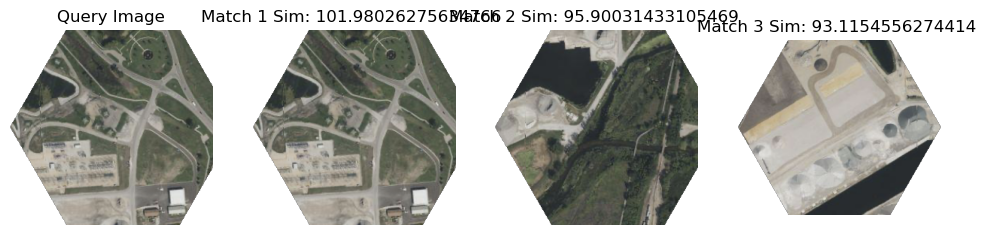

In [207]:
query ='/Users/ethanweilheimer/school/research/gpd-denied-navigation/images/test/1350.001908654709_519.6152422706632.png'
query, retrieved_images, distances = retrieve_similar_images(query, model, index, image_paths, top_k=3)
visualize_results(query, retrieved_images, distances[0])